# Question 3 and 4

In [314]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Loading and cleaning

In [315]:
cases_state = pd.read_csv('./data/cases_state.csv')
cases_state.drop(columns=['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'Unnamed: 0.1.1.1'], inplace=True)

deaths_state = pd.read_csv('./data/deaths_state.csv')
deaths_state.fillna(0, inplace=True)

tests_state = pd.read_csv('./data/tests_state.csv')
tests_state.fillna(0, inplace=True)
tests_state.drop(columns=['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'Unnamed: 0.1.1.1', 'Unnamed: 0.1.1.1.1'], inplace=True)
tests_state.rename(columns={'total': 'tests'}, inplace=True)

quarantine_state = pd.read_csv('./data/pkrc.csv')
quarantine_state.fillna(0, inplace=True)
quarantine_state.rename(columns={'beds': 'pkrc_beds', 'admitted_pui': 'pkrc_admitted_pui', 'admitted_covid': 'pkrc_admitted_covid', 'discharge_covid': 'pkrc_discharge_covid', 'admitted_total': 'pkrc_admitted_total'}, inplace=True)

icu_state = pd.read_csv('./data/icu.csv')
icu_state.fillna(0, inplace=True)

hospital = pd.read_csv('./data/hospital.csv')
hospital.fillna(0, inplace=True)

population_state = pd.read_csv('./data/population.csv', index_col=0)
population_state.fillna(0, inplace=True)

In [316]:
#create a dataframe that only store the data of the states we need only

states_list = ['Pahang', 'Kedah', 'Johor', 'Selangor']
states = {}

relevant_columns = ['cases_new', 'deaths_new', 'tests', 'admitted_covid', 'discharge_covid', 'pkrc_covid', 'pkrc_admitted_covid', 'pkrc_discharge_covid', 'icu_covid', 'hosp_covid', 'vent_covid', 'beds_covid', 'pkrc_beds']
for state in states_list:
    df = cases_state[cases_state['state'] == state]
    df = df.merge(deaths_state[deaths_state['state'] == state], how='inner', on=['date', 'state'], )
    df.fillna(0, inplace=True)
    df = df.merge(quarantine_state[quarantine_state['state'] == state], how='inner', on=['date', 'state'])
    df.fillna(0, inplace=True)
    df = df.merge(icu_state[icu_state['state'] == state], how='inner', on=['date', 'state'])
    df.fillna(0, inplace=True)
    df = df.merge(hospital[hospital['state'] == state], how='inner', on=['date', 'state'])
    df.fillna(0, inplace=True)
    df = df.merge(tests_state[tests_state['state'] == state], how='left', on=['date', 'state'])
    df.fillna(0, inplace=True)
    df.set_index('date', inplace=True)
    print(df.columns)
    df.drop(columns=[col for col in df.columns if col not in relevant_columns], inplace=True)
    states[state] = df

Index(['state', 'cases_import', 'cases_new', 'cases_recovered', 'deaths_new',
       'deaths_new_dod', 'deaths_bid', 'deaths_bid_dod', 'pkrc_beds',
       'pkrc_admitted_pui', 'pkrc_admitted_covid', 'pkrc_admitted_total',
       'discharge_pui', 'pkrc_discharge_covid', 'discharge_total',
       'pkrc_covid', 'pkrc_pui', 'pkrc_noncovid', 'beds_icu', 'beds_icu_rep',
       'beds_icu_total', 'beds_icu_covid', 'vent', 'vent_port', 'icu_covid',
       'icu_pui', 'icu_noncovid', 'vent_covid', 'vent_pui', 'vent_noncovid',
       'beds', 'beds_covid', 'beds_noncrit', 'admitted_pui', 'admitted_covid',
       'admitted_total', 'discharged_pui', 'discharged_covid',
       'discharged_total', 'hosp_covid', 'hosp_pui', 'hosp_noncovid', 'rtk-ag',
       'pcr', 'tests'],
      dtype='object')
Index(['state', 'cases_import', 'cases_new', 'cases_recovered', 'deaths_new',
       'deaths_new_dod', 'deaths_bid', 'deaths_bid_dod', 'pkrc_beds',
       'pkrc_admitted_pui', 'pkrc_admitted_covid', 'pkrc_admitt

In [317]:
states['Pahang']

,cases_new,deaths_new,pkrc_beds,pkrc_admitted_covid,pkrc_discharge_covid,pkrc_covid,icu_covid,vent_covid,beds_covid,admitted_covid,hosp_covid,tests
date,,,,,,,,,,,,
2020-04-09,14,0,66,16,0,36,3,3,504,13,90,0.0
2020-04-10,4,0,66,1,3,28,4,3,497,4,87,0.0
2020-04-11,27,0,66,6,2,32,4,3,497,29,109,0.0
2020-04-12,11,0,66,0,4,28,4,3,497,9,116,0.0
2020-04-13,0,0,66,1,8,21,4,3,497,0,114,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-01,715,3,4265,325,281,3080,41,20,734,45,454,7564.0
2021-09-02,599,0,4265,248,320,2831,43,21,734,52,449,6444.0
2021-09-03,559,4,4265,273,291,3003,44,28,734,61,452,7182.0


Remove columns that are unrelated to covid first as the first round of feature selection.

## Finding Best Features

Techniques Used:
1. Variance Threshold
2. SelectKBest with Mutual Info Regression
3. SelectKBest with Chi-Squared
4. Recursive Feature Elimination

In [318]:
#Streamlit

#We have used four methods to find the best features,which are the Variance Threshold,SelectKBest with Mutual Info Regression,
#SelectKBest with Chi-Squared and Recursive Feature Elimination.The way we decide which features to pick is be choosing the
#top four features that appeared the most in all of the methods.Hence,we can find the best features by using this way.

#Streamlit

In [319]:
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_regression, RFE, VarianceThreshold
from sklearn.linear_model import LinearRegression
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor

#the function we use to find the best features

def get_best_features(df,display_scatter_plots = 0):
    X = df.drop(columns=['cases_new'], axis=1)
    y = df['cases_new']
    print(X.columns)
    # selector = VarianceThreshold(3)
    # selector.fit(df.drop(columns=['state']))
    # variance_best = df.columns[selector.get_support()]

    selector = SelectKBest(mutual_info_regression, k=6)
    selector.fit(X, y)
    mutual_info_best = X.columns[selector.get_support()]

    rfe_selector = RFE(LinearRegression(), n_features_to_select=10)
    rfe_selector.fit(X, y)
    rfe_best = X.columns[rfe_selector.get_support()]

    rf = RandomForestRegressor(n_jobs=4, oob_score=True)
    boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=0)
    boruta.fit(X.values, y.ravel())
    boruta_best = [X.columns[i] for i, x in enumerate(boruta.support_) if x]
    print(boruta_best)

    columns = X.columns
    columns_count = {}
    for column in columns:
        columns_count[column] = list(mutual_info_best).count(column) + list(rfe_best).count(column) + list(boruta_best).count(column)
    
    best_features = sorted(columns_count, key=columns_count.get)[-6:]
        
    if display_scatter_plots == 1:
        print("The best four features")
        display(best_features)
        print("")
        for num in range(len(best_features)):
            sns.scatterplot(x= best_features[num], y="cases_new", data=df)
            z = np.polyfit(df[best_features[num]], df['cases_new'], 1)
            p = np.poly1d(z)
            plt.plot(df[best_features[num]],p(df[best_features[num]]),"r--")
            plt.title('Scatter plot of ' + best_features[num] + ' and daily new cases')
            plt.xlabel(best_features[num])
            plt.ylabel("daily new cases")
            plt.show()

    # if 'tests' not in best_features:
    #     best_features.append('tests')

    return best_features

Index(['deaths_new', 'pkrc_beds', 'pkrc_admitted_covid',
       'pkrc_discharge_covid', 'pkrc_covid', 'icu_covid', 'vent_covid',
       'beds_covid', 'admitted_covid', 'hosp_covid', 'tests'],
      dtype='object')
Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	7
Tentative: 	2
Rejected: 	2
Iteration: 	9 / 100
Confirmed: 	7
Tentative: 	2
Rejected: 	2
Iteration: 	10 / 100
Confirmed: 	7
Tentative: 	2
Rejected: 	2
Iteration: 	11 / 100
Confirmed: 	7
Tentative: 	2
Rejected: 	2
Iteration: 	12 / 100
Confirmed: 	7
Tentative: 	2
Rejected: 	2
Iteration: 	13 / 100
Confirmed: 	7
Tentative

['tests',
 'pkrc_admitted_covid',
 'pkrc_covid',
 'icu_covid',
 'vent_covid',
 'hosp_covid']

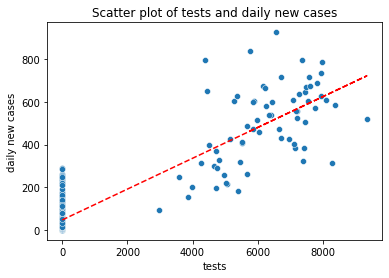

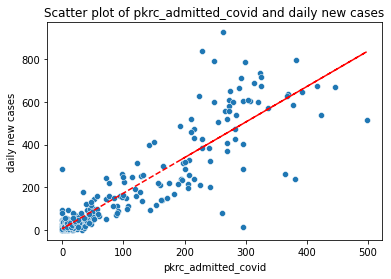

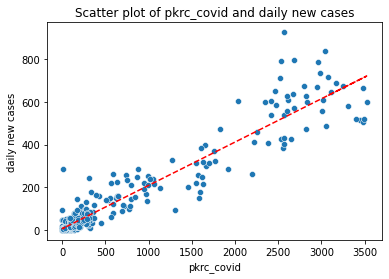

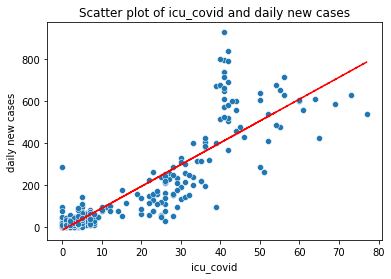

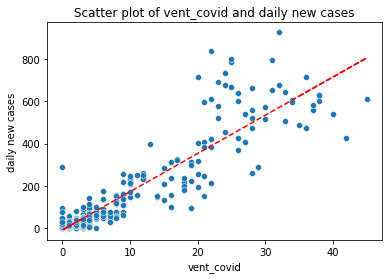

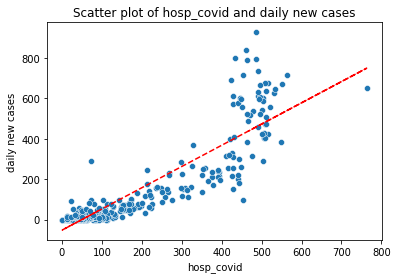

In [320]:
pahang_features = get_best_features(states['Pahang'],display_scatter_plots = 1)

#Streamlit

#Based on our result,we know that the four best features to daily new cases for Pahang are 'quarantine' , 'discharge_quarantine',
#'icu' and 'hospital_admitted'.For 'quarantine', 'discharge quaratine' and 'icu 'features,we can see a relatively strong linear positve 
#relationship with the daily new cases and for 'hospital_admitted' feature's relationship with the daily cases are showed to be more weaker
#and the plot in the graph is widely spread.For all the scatter plot also show that when the xlabel's value is near to zero ,
#there are few outlier,which indicated that the daily new cases is very high but the four features value are very low.
#Hence,we might need to do some research about what is the reasons causing these outlier in each graph.

#Streamlit

Index(['deaths_new', 'pkrc_beds', 'pkrc_admitted_covid',
       'pkrc_discharge_covid', 'pkrc_covid', 'icu_covid', 'vent_covid',
       'beds_covid', 'admitted_covid', 'hosp_covid', 'tests'],
      dtype='object')
Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	6
Tentative: 	4
Rejected: 	1
Iteration: 	9 / 100
Confirmed: 	6
Tentative: 	4
Rejected: 	1
Iteration: 	10 / 100
Confirmed: 	6
Tentative: 	4
Rejected: 	1
Iteration: 	11 / 100
Confirmed: 	6
Tentative: 	4
Rejected: 	1
Iteration: 	12 / 100
Confirmed: 	6
Tentative: 	4
Rejected: 	1
Iteration: 	13 / 100
Confirmed: 	6
Tentative

['vent_covid',
 'pkrc_covid',
 'icu_covid',
 'beds_covid',
 'admitted_covid',
 'hosp_covid']

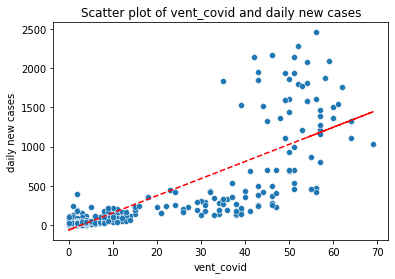

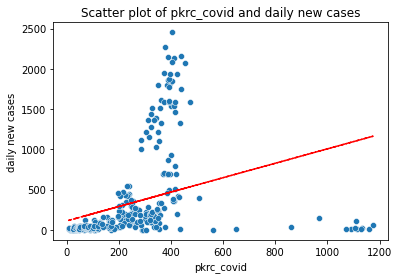

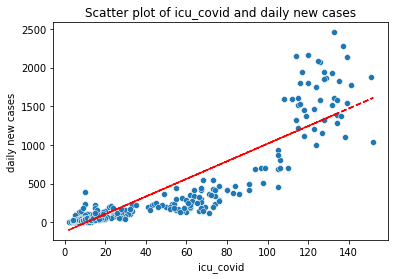

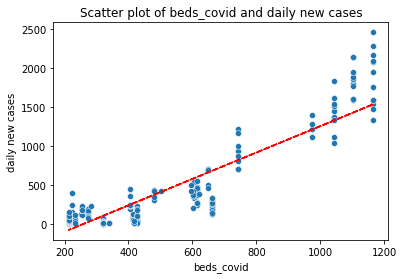

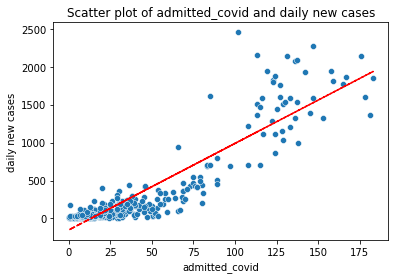

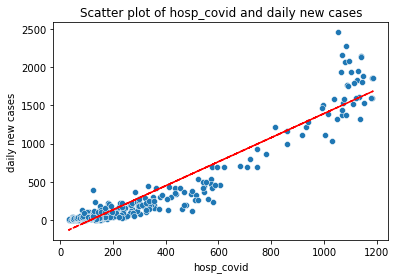

In [321]:
#Streamlit

#Based on our result,we know that the four best features to daily new cases for Kedah are 'quarantine' , 'discharge_quarantine',
#'icu' and 'hospital_admitted'.For 'quarantine' and 'discharge quaratine' have very similar pattern.However,it is a very weak 
#positive linear relationship and most of the plots are saturated at the lower left region in the graph.For 'icu' and
#'hospital_admitted' features show a relatively more strong and linear relationship with the daily new cases.Moreover,there are few
#extreme outlier in both of the bottom left region of the scatter plots.Hence,based on the
#four scatter plots,'icu' and 'hospital_admitted' features are considered as a better indicator than another two features.
#Moreover,For all the scatter plots,when the xlabel's value is near to zero also show the same problem happen in the Pahang cases,
#which is there are some outlier that have relatively high daily new cases.So,we can conclude that they might be caused by the
#same reason.

#Streamlit

kedah_features = get_best_features(states['Kedah'],display_scatter_plots = 1)

Index(['deaths_new', 'pkrc_beds', 'pkrc_admitted_covid',
       'pkrc_discharge_covid', 'pkrc_covid', 'icu_covid', 'vent_covid',
       'beds_covid', 'admitted_covid', 'hosp_covid', 'tests'],
      dtype='object')
Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	7
Tentative: 	4
Rejected: 	0
Iteration: 	9 / 100
Confirmed: 	7
Tentative: 	4
Rejected: 	0
Iteration: 	10 / 100
Confirmed: 	7
Tentative: 	4
Rejected: 	0
Iteration: 	11 / 100
Confirmed: 	7
Tentative: 	4
Rejected: 	0
Iteration: 	12 / 100
Confirmed: 	7
Tentative: 	4
Rejected: 	0
Iteration: 	13 / 100
Confirmed: 	7
Tentative

['pkrc_beds',
 'pkrc_covid',
 'icu_covid',
 'vent_covid',
 'beds_covid',
 'hosp_covid']

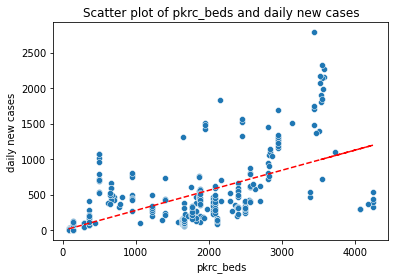

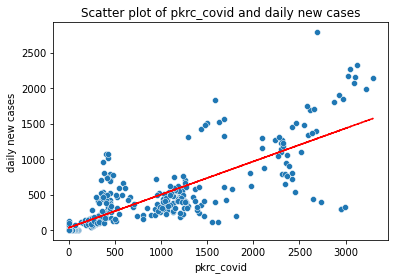

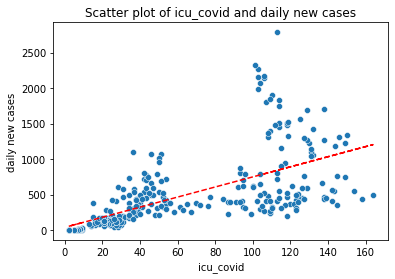

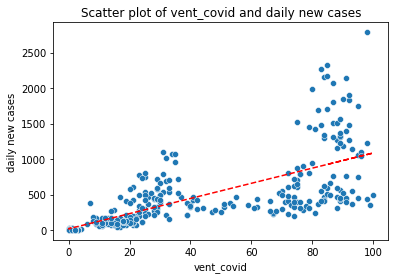

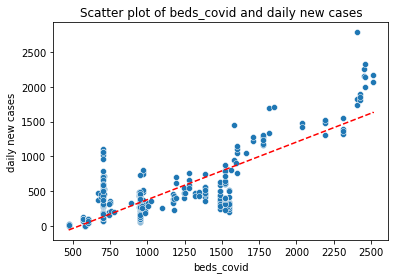

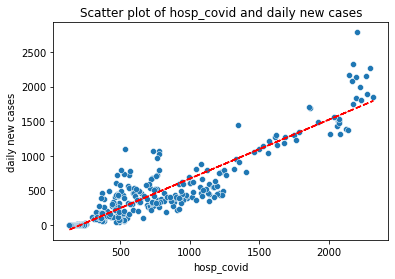

In [322]:
johor_features = get_best_features(states['Johor'],display_scatter_plots = 1)

#Streamlit

#Based on the graph
#Based on our result,we know that the four best features to daily new cases for Johor are 'hospital_discharged' , 
#'icu','discharge_quarantine' and 'hospital_admitted'.For 'hospital_discharged' and 'hospital_admitted' features' scatter
#plots we can see that both of them have a relatively strong linear postive relationship with the daily new cases.
#For 'icu' and 'discharge_quarantine',their plots in the graph is relatively wide spread and less saturated to the the trend line
#when compare to the other features.Hence,we can conclude that all four features also can be a good indicator for daily new cases
#but 'hospital_discharged' and 'hospital_admitted' features are considered as the better indicator with stronger relationship
#with daily new features based on their scatter plots.Furthermore,the same problem is happen to all this 4 features,which is 
#there are few outliers at the top left of each of the scatters plots and it is further proved that there is something that
#what is the reason that causing this problem.

#Streamlit

Index(['deaths_new', 'pkrc_beds', 'pkrc_admitted_covid',
       'pkrc_discharge_covid', 'pkrc_covid', 'icu_covid', 'vent_covid',
       'beds_covid', 'admitted_covid', 'hosp_covid', 'tests'],
      dtype='object')
Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	8
Tentative: 	1
Rejected: 	2
Iteration: 	9 / 100
Confirmed: 	8
Tentative: 	1
Rejected: 	2
Iteration: 	10 / 100
Confirmed: 	8
Tentative: 	1
Rejected: 	2
Iteration: 	11 / 100
Confirmed: 	8
Tentative: 	1
Rejected: 	2
Iteration: 	12 / 100
Confirmed: 	8
Tentative: 	1
Rejected: 	2
Iteration: 	13 / 100
Confirmed: 	8
Tentative

['vent_covid',
 'pkrc_beds',
 'icu_covid',
 'beds_covid',
 'admitted_covid',
 'hosp_covid']

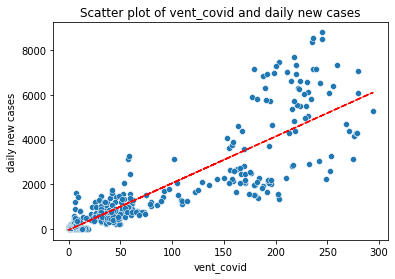

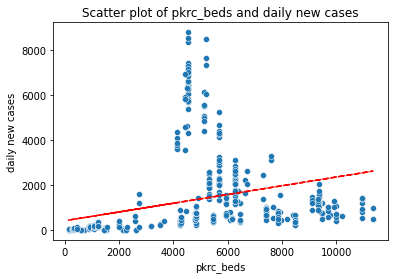

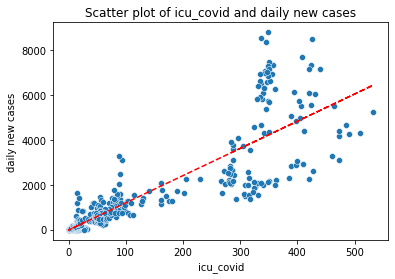

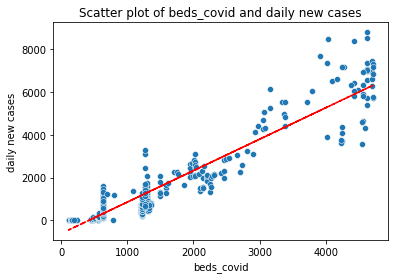

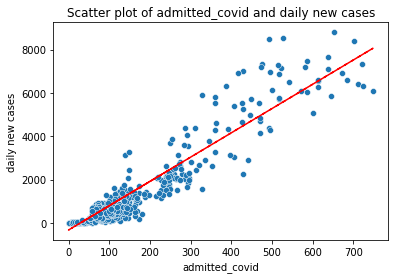

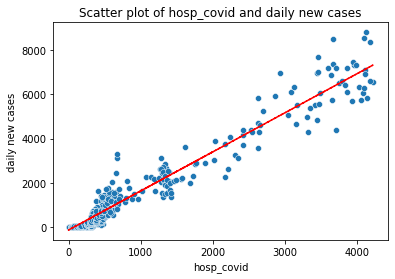

In [323]:
selangor_features = get_best_features(states['Selangor'],display_scatter_plots = 1)
#Streamlit

#Based on the graph
#Based on our result,we know that the four best features to daily new cases for Selangor are 'quarantine' , 
#'icu','hospital_discharged' and 'hospital_admitted'.For 'hospital_discharged' and 'hospital_admitted' features' scatter
#plots we can see that both of them have a relatively strong linear postive relationship with the daily new cases.
#For 'quarantine' and 'icu',their plots in the graph is relatively wide spread and less saturated to the the trend line
#when compare to the other features.Hence,we can conclude that all four features also can be a good indicator for daily new cases
#but 'hospital_discharged' and 'hospital_admitted' features are considered as the better indicator with stronger relationship
#with daily new features based on their scatter plots.Lastly,for Selagor state also have the same issue,but the location of the group
#of data is around the medium left region rather than the top left region,it is caused by the relatively high daily new cases 
#of Selangor compare to other states.So,it further prove that there is somthings that causing this to be happen.

#Streamlit

## Modeling
Classification:
1. Support Vector Machine
2. Decision Tree
3. Random Forest Classifier

Regression:
1. Support Vector Machine
2. Linear Regression
3. Random Forest Regressor

In [324]:
from sklearn.svm import SVR, SVC
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score, mean_squared_error

In [325]:
#Streamlit

#The regression models that we decided to use are Support Vector Machine,Linear Refression and Random Forest Regressor.
#For the evalution method that we use for the regression models are score function and mean squared error.
#For the features we decide to use to train our models are based on the best four features we find for each states in question 3.
#Other than thats,we add another extra feature which is the 'test' feature into our training model.It is because based on
#our result,we find out that add added the 'test' feature,it will cause a great impact to our result and helping to 
#increase the accurancy of our models


#Streamlit

## Regression

In [349]:
def svm_regression(df, features):
    X = df[features]
    X = MinMaxScaler().fit_transform(X)
    y = df['cases_new']
    y = MinMaxScaler().fit_transform(y.values.reshape(-1, 1))
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

    svr_rbf = SVR(kernel='rbf', C=1e5, gamma=0.001)
    svr_rbf.fit(X_train, y_train.ravel())
    svr_rbf_pred = svr_rbf.predict(X_test)

    svr_rbf_score = svr_rbf.score(X_test, y_test)
    svr_rbf_mse = mean_squared_error(y_test, svr_rbf_pred)

    print('SVR RBF Score: ', svr_rbf_score)
    print('SVR RBF MSE: ', svr_rbf_mse)
    print('')


In [327]:
def linear_regression(df, features):
    X = df[features]
    X = MinMaxScaler().fit_transform(X)
    y = df['cases_new']
    y = MinMaxScaler().fit_transform(y.values.reshape(-1, 1))
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

    lin_reg = LinearRegression()
    lin_reg.fit(X_train, y_train)
    lin_reg_pred = lin_reg.predict(X_test)

    lin_reg_score = lin_reg.score(X_test, y_test)
    lin_reg_mse = mean_squared_error(y_test, lin_reg_pred)

    print('Linear Regression Score: ', lin_reg_score)
    print('Linear Regression MSE: ', lin_reg_mse)
    print('')

In [351]:
def random_forest_regressor(df, features):
    X = df[features]
    X = MinMaxScaler().fit_transform(X)
    y = df['cases_new']
    y = MinMaxScaler().fit_transform(y.values.reshape(-1, 1))

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

    rf_reg = RandomForestRegressor(n_estimators=10, random_state=42)
    rf_reg.fit(X_train, y_train.ravel())
    rf_reg_pred = rf_reg.predict(X_test)

    rf_reg_score = rf_reg.score(X_test, y_test)
    rf_reg_mse = mean_squared_error(y_test, rf_reg_pred)

    print('Random Forest Regressor Score: ', rf_reg_score)
    print('Random Forest Regressor MSE: ', rf_reg_mse)
    print('')

In [352]:
best_features = {}
best_features['Pahang'] = pahang_features
best_features['Kedah'] = kedah_features
best_features['Selangor'] = selangor_features
best_features['Johor'] = johor_features

In [353]:
def print_result_for_regression_models(state):
    svm_regression(states[state], best_features[state])
    linear_regression(states[state], best_features[state])
    random_forest_regressor(states[state], best_features[state])

In [354]:
print_result_for_regression_models('Pahang')

SVR RBF Score:  0.8403670633721505
SVR RBF MSE:  0.00820245806451263

Linear Regression Score:  0.9027166552969976
Linear Regression MSE:  0.004998733796160033

Random Forest Regressor Score:  0.9109786769357175
Random Forest Regressor MSE:  0.004574204325918658



In [332]:
print_result_for_regression_models('Kedah')

SVR RBF Score:  0.9564926404873783
SVR RBF MSE:  0.002930415570811384

Linear Regression Score:  0.9476851227846464
Linear Regression MSE:  0.003523641344689819

Random Forest Regressor Score:  0.9663215147713625
Random Forest Regressor MSE:  0.002268396855633339



/Users/SidharrthNagappan/.virtualenvs/multitask-bert/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/var/folders/sg/4x_5htrx3y7fm7z77wcz8c_40000gn/T/ipykernel_39868/1821960476.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_reg.fit(X_train, y_train)


In [333]:
print_result_for_regression_models('Johor')

/Users/SidharrthNagappan/.virtualenvs/multitask-bert/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/var/folders/sg/4x_5htrx3y7fm7z77wcz8c_40000gn/T/ipykernel_39868/1821960476.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_reg.fit(X_train, y_train)


SVR RBF Score:  0.8440146517059108
SVR RBF MSE:  0.0061779918754983525

Linear Regression Score:  0.8662445038291385
Linear Regression MSE:  0.005297551197493759

Random Forest Regressor Score:  0.9051059920396347
Random Forest Regressor MSE:  0.003758394083957874



In [334]:
print_result_for_regression_models('Selangor')

/Users/SidharrthNagappan/.virtualenvs/multitask-bert/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


SVR RBF Score:  0.9461939461920579
SVR RBF MSE:  0.002877390656620074

Linear Regression Score:  0.9608172240040476
Linear Regression MSE:  0.00209538045576851

Random Forest Regressor Score:  0.9565512670186063
Random Forest Regressor MSE:  0.0023235113797583314



/var/folders/sg/4x_5htrx3y7fm7z77wcz8c_40000gn/T/ipykernel_39868/1821960476.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_reg.fit(X_train, y_train)


In [335]:

#Streamlit Conclude for the Regression model

#Based on the result we get from our Score Function, the Random Forest Regressor has the higest score compare to other method 
#in each of the states.
#For the result of the MSE,the Random Forest Regressor also score the best result by scoring the lowest error in all of states.
#Hence,we can conclude that the Random Forest Regressor is the best regression model for us to predict our results among all of
#the other regression model.

#Streamlit

## Classification

In [336]:
from sklearn.metrics import classification_report

In [337]:
for state in states_list:
    states[state]['cases_binned'] = pd.cut(states[state]['cases_new'], bins=[-1, states[state]['cases_new'].max()/3, 2/3 * states[state]['cases_new'].max(), states[state]['cases_new'].max()], labels=['Low', 'Medium', 'High'])

In [338]:
def supportvectormachine_classification(df, features):
    X = df[features]
    X = MinMaxScaler().fit_transform(X)
    y = df['cases_binned']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

    svc = SVC(kernel='rbf', C=1e5, gamma=0.001)
    svc.fit(X_train, y_train)
    svc_pred = svc.predict(X_test)

    svc_score = svc.score(X_test, y_test)
    svc_f1_score = f1_score(y_test, svc_pred, average='weighted')

    # print classification report
    print(classification_report(y_test, svc_pred))

    print('SVC Score: ', svc_score)
    print('SVC F1 Score: ', svc_f1_score)
    print('')

In [339]:
def randomforest_classification(df, features):
    X = df[features]
    X = MinMaxScaler().fit_transform(X)
    y = df['cases_binned']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

    rf_clf = RandomForestClassifier(n_estimators=5, random_state=42)
    rf_clf.fit(X_train, y_train)
    rf_clf_pred = rf_clf.predict(X_test)

    rf_clf_score = rf_clf.score(X_test, y_test)
    rf_clf_f1_score = f1_score(y_test, rf_clf_pred, average='weighted')

    # print classification report
    print(classification_report(y_test, rf_clf_pred))

    print('Random Forest Classification Score: ', rf_clf_score)
    print('Random Forest Classification F1 Score: ', rf_clf_f1_score)
    print('')

In [340]:
def logistic_regression(df, features):
    X = df[features]
    X = MinMaxScaler().fit_transform(X)
    y = df['cases_binned']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

    log_reg = LogisticRegression(random_state=42)
    log_reg.fit(X_train, y_train)
    log_reg_pred = log_reg.predict(X_test)

    log_reg_score = log_reg.score(X_test, y_test)
    log_reg_f1_score = f1_score(y_test, log_reg_pred, average='weighted')

    # print classification report
    print(classification_report(y_test, log_reg_pred))

    print('Logistic Regression Score: ', log_reg_score)
    print('Logistic Regression F1 Score: ', log_reg_f1_score)
    print('')

In [341]:
def print_result_for_classificaiton_models(state) :
    supportvectormachine_classification(states[state], best_features[state])
    randomforest_classification(states[state], best_features[state])
    logistic_regression(states[state], best_features[state])

In [342]:
print_result_for_classificaiton_models('Pahang')

              precision    recall  f1-score   support

        High       0.00      0.00      0.00         4
         Low       1.00      1.00      1.00        59
      Medium       0.60      0.86      0.71         7

    accuracy                           0.93        70
   macro avg       0.53      0.62      0.57        70
weighted avg       0.90      0.93      0.91        70

SVC Score:  0.9285714285714286
SVC F1 Score:  0.9134453781512605

              precision    recall  f1-score   support

        High       0.33      0.25      0.29         4
         Low       1.00      0.98      0.99        59
      Medium       0.56      0.71      0.63         7

    accuracy                           0.91        70
   macro avg       0.63      0.65      0.63        70
weighted avg       0.92      0.91      0.91        70

Random Forest Classification Score:  0.9142857142857143
Random Forest Classification F1 Score:  0.9144797662654808

              precision    recall  f1-score   support

 

/Users/SidharrthNagappan/.virtualenvs/multitask-bert/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/SidharrthNagappan/.virtualenvs/multitask-bert/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/SidharrthNagappan/.virtualenvs/multitask-bert/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavi

In [343]:
print_result_for_classificaiton_models('Kedah')

              precision    recall  f1-score   support

        High       0.60      0.50      0.55         6
         Low       1.00      1.00      1.00        54
      Medium       0.67      0.75      0.71         8

    accuracy                           0.93        68
   macro avg       0.76      0.75      0.75        68
weighted avg       0.93      0.93      0.93        68

SVC Score:  0.9264705882352942
SVC F1 Score:  0.9252909720037747

              precision    recall  f1-score   support

        High       0.67      0.67      0.67         6
         Low       1.00      1.00      1.00        54
      Medium       0.75      0.75      0.75         8

    accuracy                           0.94        68
   macro avg       0.81      0.81      0.81        68
weighted avg       0.94      0.94      0.94        68

Random Forest Classification Score:  0.9411764705882353
Random Forest Classification F1 Score:  0.9411764705882353

              precision    recall  f1-score   support

 

/Users/SidharrthNagappan/.virtualenvs/multitask-bert/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/SidharrthNagappan/.virtualenvs/multitask-bert/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/SidharrthNagappan/.virtualenvs/multitask-bert/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavi

In [344]:
print_result_for_classificaiton_models('Johor')

              precision    recall  f1-score   support

        High       0.50      0.50      0.50         2
         Low       0.98      1.00      0.99        53
      Medium       0.89      0.80      0.84        10

    accuracy                           0.95        65
   macro avg       0.79      0.77      0.78        65
weighted avg       0.95      0.95      0.95        65

SVC Score:  0.9538461538461539
SVC F1 Score:  0.9527034696734649

              precision    recall  f1-score   support

        High       0.50      0.50      0.50         2
         Low       0.98      0.98      0.98        53
      Medium       0.80      0.80      0.80        10

    accuracy                           0.94        65
   macro avg       0.76      0.76      0.76        65
weighted avg       0.94      0.94      0.94        65

Random Forest Classification Score:  0.9384615384615385
Random Forest Classification F1 Score:  0.9384615384615385

              precision    recall  f1-score   support

 

/Users/SidharrthNagappan/.virtualenvs/multitask-bert/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/SidharrthNagappan/.virtualenvs/multitask-bert/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/SidharrthNagappan/.virtualenvs/multitask-bert/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavi

In [345]:
print_result_for_classificaiton_models('Selangor')

              precision    recall  f1-score   support

        High       0.83      0.83      0.83         6
         Low       1.00      0.99      0.99        89
      Medium       0.83      0.91      0.87        11

    accuracy                           0.97       106
   macro avg       0.89      0.91      0.90       106
weighted avg       0.97      0.97      0.97       106

SVC Score:  0.9716981132075472
SVC F1 Score:  0.972286722005163

              precision    recall  f1-score   support

        High       0.40      0.33      0.36         6
         Low       1.00      1.00      1.00        89
      Medium       0.67      0.73      0.70        11

    accuracy                           0.93       106
   macro avg       0.69      0.69      0.69       106
weighted avg       0.93      0.93      0.93       106

Random Forest Classification Score:  0.9339622641509434
Random Forest Classification F1 Score:  0.9323961518383177

              precision    recall  f1-score   support

  

In [346]:

#Streamlit Conclude for the classifcaiton model

#Based our the result for Pahang,we will see that all 3 method all get the same result for the Score Function but there are
#some slightly different for the F1 score,for the F1 score,the SVC model score the best.So,we can concludle that the SVC
#model is best fit for Pahang to predict the cases.
#Next,for Kedah,both the Logistic Regression model and the SVC model also score the highest result in the Score Function but when
#come to the F1 Score result,the SVC model will score slightly better than the Logistic Regression.In conclusion,for Kedah,SVC
#model also is the best model in predicting the cases.
#Moreover,for Johor and selangor,the SVC model also score the highest result in the Score Function and F1 Score.
#Hence,based on our result we can conclude that the SVC model has the best overall outcome compare to other models.

#Streamlit

In [347]:
#Streamlit Conclude for the both model

#To conclude for both classification model and regression model,we can check on their Score Function result.It is because 
#for both type of models we also used this evalution metric.When we are trying to compare the SVC classification model and the
#Random Forest Regressor,which both also score the best overall result in their own sector,the SVC classification is also score
#around 1 to 5 percent better than the Random Forest Regressor.In conclusion,among all the models we used,the SVC classification
#model is the best model to predict the daily cases.

#Streamlit

In [348]:
best_features

{'Pahang': ['tests',
  'pkrc_admitted_covid',
  'pkrc_covid',
  'icu_covid',
  'vent_covid',
  'hosp_covid'],
 'Kedah': ['vent_covid',
  'pkrc_covid',
  'icu_covid',
  'beds_covid',
  'admitted_covid',
  'hosp_covid'],
 'Selangor': ['vent_covid',
  'pkrc_beds',
  'icu_covid',
  'beds_covid',
  'admitted_covid',
  'hosp_covid'],
 'Johor': ['pkrc_beds',
  'pkrc_covid',
  'icu_covid',
  'vent_covid',
  'beds_covid',
  'hosp_covid']}